# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem.porter import PorterStemmer
import nlp
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import warnings
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')

# Loading the dataset

In [2]:
df = pd.read_csv("Twitter Sentiments.csv")
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


# Preprocessing dataset

In [4]:
tweet = df["tweet"]

In [5]:
# nltk.download('stopwords')
from nltk.corpus import stopwords

courp = []
for i in range(0, np.shape(tweet)[0]):
    review = re.sub(r'\s*[@]+\w+\s*', '', tweet[i])
    review = re.sub(r'((www.[^s]+)|(https?://[^s]+))','',review)
    review = re.sub('[^a-zA-Z#]', ' ', review)
    review = review.lower( )
    review = review.split()
    ps = PorterStemmer() 
    review = [ps.stem(word) for word in review]
    review = ' '.join(review)
    courp.append(review)
df["clean_tweet"] = pd.DataFrame(courp)

In [6]:
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunct and is so selfish he...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank for #lyft credit i can t use caus they d...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguid societi now #motiv


# Exploratory Data Analysis

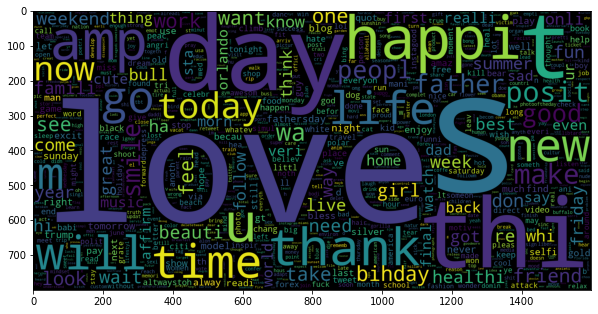

In [7]:
# All tweets
from wordcloud import WordCloud
all_tweets = " ".join([sentence for sentence in df['clean_tweet']])
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(all_tweets)
plt.imshow(wc)

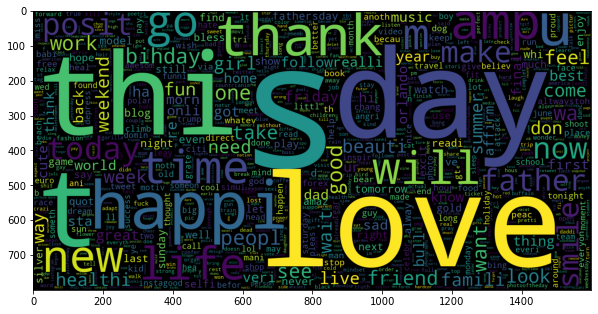

In [8]:
# frequent words visualization for +ve
positive_tweets = " ".join([sentence for sentence in df['clean_tweet'][df['label']==0]])

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(positive_tweets)
plt.imshow(wc)

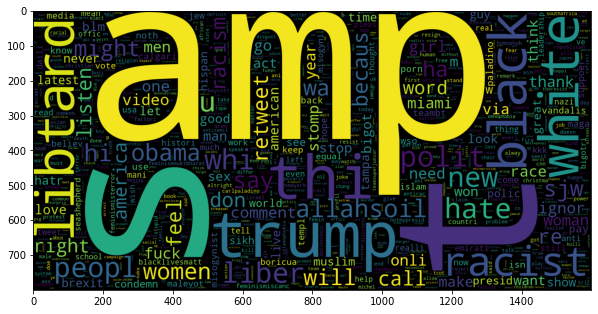

In [9]:
# frequent words visualization for -ve
positive_tweets = " ".join([sentence for sentence in df['clean_tweet'][df['label']==1]])

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(positive_tweets)
plt.imshow(wc)

In [10]:
# extract the hashtag
def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags

In [11]:
# extract hashtags from non-racist/sexist tweets
positive_ht = hashtag_extract(df['tweet'][df['label']==0])

# extract hashtags from racist/sexist tweets
negative_ht = hashtag_extract(df['tweet'][df['label']==1])

In [12]:
ht_positive = sum(positive_ht, [])
ht_negative = sum(negative_ht, [])

In [13]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,run,33
1,lyft,2
2,disapointed,1
3,getthanked,2
4,model,364


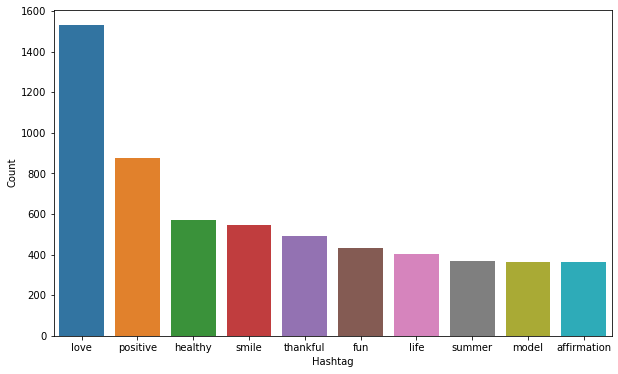

In [14]:
# select top 10 positive hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(10,6))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [15]:
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,cnn,9
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,2


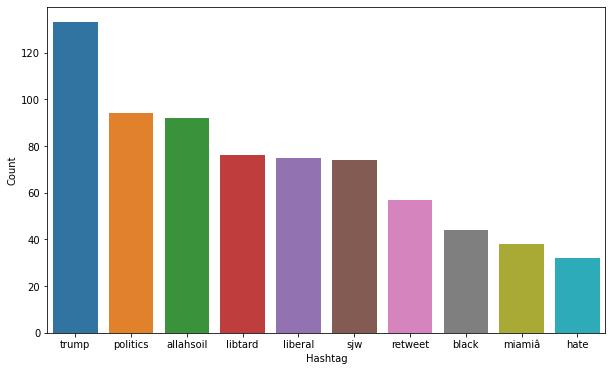

In [16]:
# select top 10 negative hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(10,6))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

# Input Split

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1000)
X = cv.fit_transform(df['clean_tweet']).toarray()

In [18]:
y = df["label"].values

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Train Model

In [20]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [21]:
pred = classifier.predict(X_test)
print(np.concatenate((pred.reshape(len(pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [22]:
from sklearn.metrics import f1_score
f1_score(y_test, pred)

0.5333333333333333

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, pred)
print(cm)
accuracy_score(y_test,pred)

[[5898   62]
 [ 253  180]]


0.9507273580478649

In [24]:
# use probability to get output
pred_prob = classifier.predict_proba(X_test)
pred = pred_prob[:, 1] >= 0.3
pred = pred.astype(np.int)

f1_score(y_test, pred)

0.5776699029126213

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, pred)
print(cm)
accuracy_score(y_test,pred)

[[5807  153]
 [ 195  238]]


0.9455654622243078